<a href="https://colab.research.google.com/github/AlejandroVillazonG/Tareas_INF395/blob/main/T1/T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [ ]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 7.1 MB/s eta 0:00:00


## Integrantes:

* Nombre: Alejandro Villazón (201910009-2)
* Nombre: Joaquín Aguirre (201910031-9)
* Nombre: Dominique Yessouroun (201910005-K)

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


In [ ]:
#!pip install scikit-learn

In [ ]:
#!pip install seaborn

In [ ]:
#!pip install keras

In [ ]:
#!pip install tensorflow

## Helper Functions

In [ ]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [ ]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm)
  cm_display.plot(cmap=plt.cm.OrRd)
  plt.show()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Exploración de los Datos

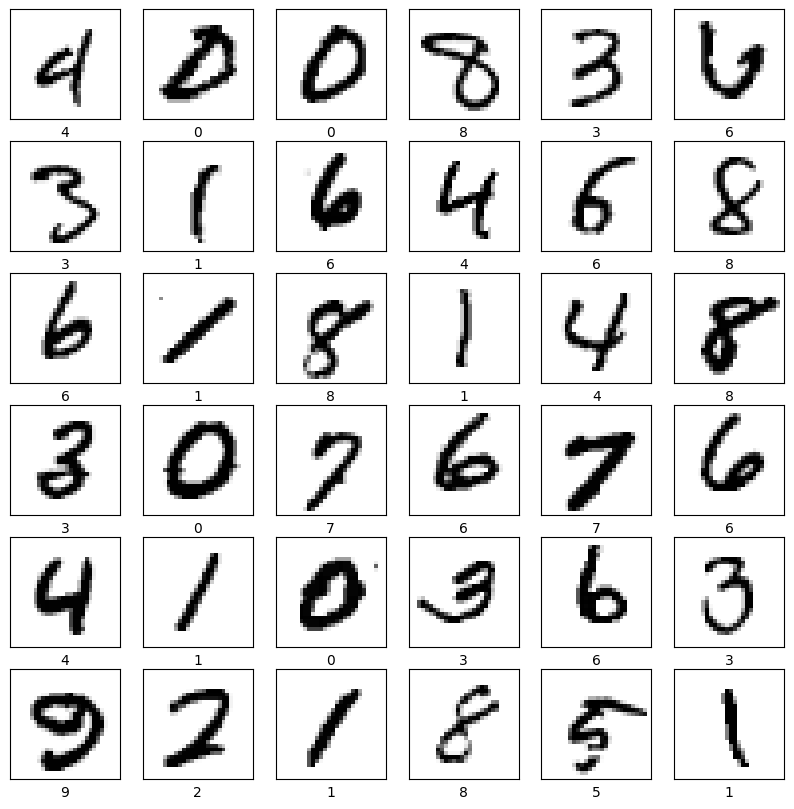

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (3.11 MB)

 Trainable params: 101,770 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

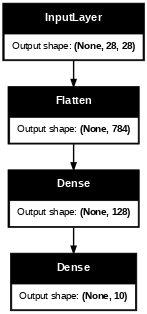

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2)

Epoch 1/20
375/375 - 9s - 25ms/step - accuracy: 0.6837 - loss: 4.8376 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 - 2s - 6ms/step - accuracy: 0.8059 - loss: 0.8962 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 - 3s - 8ms/step - accuracy: 0.8438 - loss: 0.6635 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 - 5s - 14ms/step - accuracy: 0.8666 - loss: 0.5376 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 - 4s - 11ms/step - accuracy: 0.8821 - loss: 0.4596 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 - 2s - 5ms/step - accuracy: 0.8935 - loss: 0.4059 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 - 4s - 11ms/step - accuracy: 0.9023 - loss: 0.3657 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 - 2s - 6ms/step - accuracy: 0.9091 - loss: 0.3342 - val_accuracy: 0.9021 - val_loss: 0.4528
Epoch 9/20
375/375 - 2s - 7ms/step - accuracy: 0.9139 - loss: 0.3098 - val_accuracy: 0.9072 - val_loss: 0.43

In [ ]:
print(f'Primera epoch:\nAccuracy: {history.history["accuracy"][0]}\nVal_Accuracy: {history.history["val_accuracy"][0]}')

Primera epoch:
Accuracy: 0.6836875081062317
Val_Accuracy: 0.7898333072662354


In [ ]:
print(f'Primera epoch:\nLoss: {history.history["loss"][0]}\nVal_Loss: {history.history["val_loss"][0]}')

Primera epoch:
Loss: 4.8376007080078125
Val_Loss: 1.0556691884994507


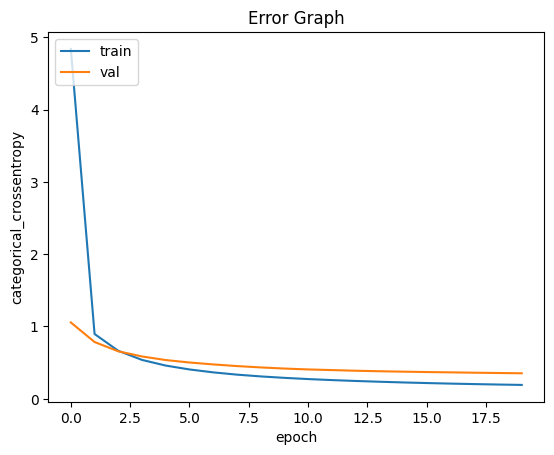

In [ ]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36804887652397156
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


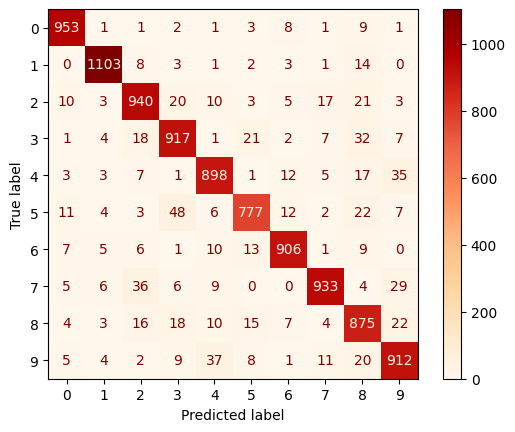

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: **'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.**

In [ ]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


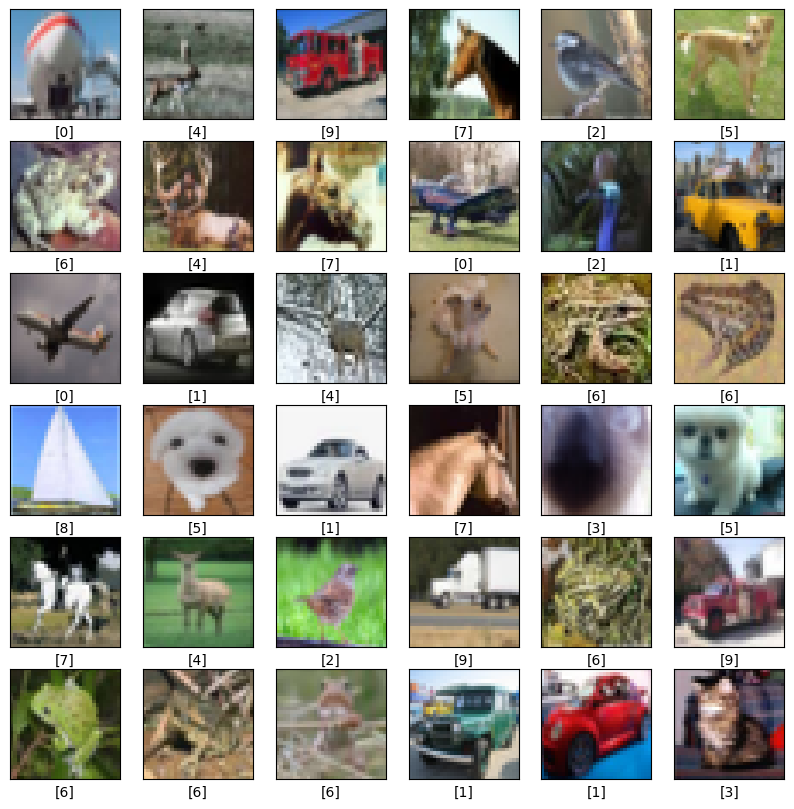

In [ ]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


Notamos que la tercera dimensión en los datos se debe a que estamos trabajando los colores en formato RGB

In [ ]:
print(f'valor máximo: {x_train.max()}')
print(f'valor mínimo: {x_train.min()}')

valor máximo: 255
valor mínimo: 0


In [ ]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (12.04 MB)

 Trainable params: 394,634 (12.04 MB)

 Non-trainable params: 0 (0.00 B)

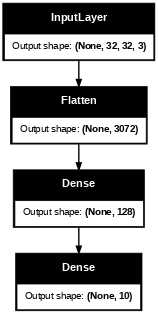

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
# definimos algunos hiperparámetros
batch_size = 128
epochs = 20
validation_split = 0.2

In [ ]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2)

Epoch 1/20
313/313 - 5s - 17ms/step - accuracy: 0.0989 - loss: 125.0115 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 - 4s - 13ms/step - accuracy: 0.1010 - loss: 2.3037 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 - 4s - 12ms/step - accuracy: 0.1008 - loss: 2.3023 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 - 4s - 12ms/step - accuracy: 0.1014 - loss: 2.3020 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 - 3s - 10ms/step - accuracy: 0.1014 - loss: 2.3019 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 - 6s - 18ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 - 4s - 13ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 - 3s - 10ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3129
Epoch 9/20
313/313 - 5s - 16ms/step - accuracy: 0.1014 - loss: 2.3018 - val_accuracy: 0.0954 - val_los

In [ ]:
print(f'Primera epoch:\nAccuracy: {history.history["accuracy"][0]}\nVal_Accuracy: {history.history["val_accuracy"][0]}')

Primera epoch:
Accuracy: 0.09892500191926956
Val_Accuracy: 0.09529999643564224


In [ ]:
print(f'Primera epoch:\nLoss: {history.history["loss"][0]}\nVal_Loss: {history.history["val_loss"][0]}')

Primera epoch:
Loss: 125.01146697998047
Val_Loss: 2.3143861293792725


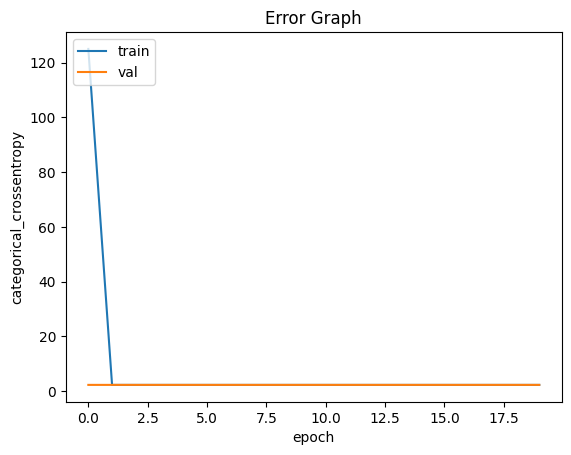

In [ ]:
plot_losses(history, loss)

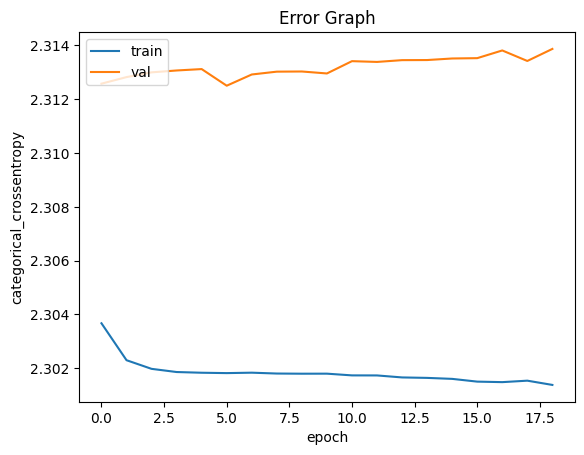

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Error Graph')
plt.ylabel(loss.name)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


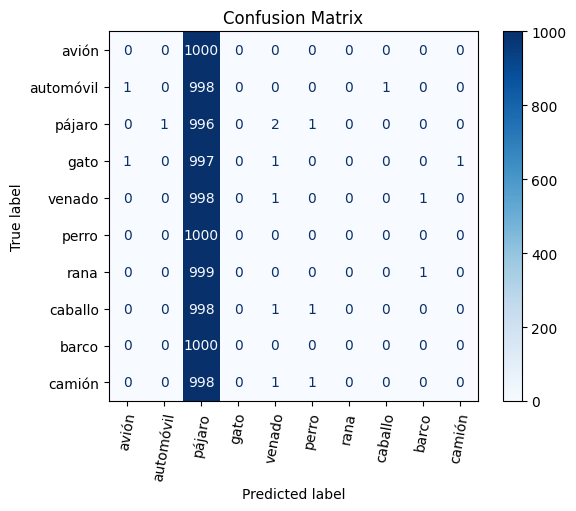

In [ ]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

LABELS = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    cmap=plt.cm.Blues,
    display_labels = LABELS,
    xticks_rotation = 80
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
#target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']
target_names = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

       avión       0.00      0.00      0.00      1000
   automóvil       0.00      0.00      0.00      1000
      pájaro       0.10      1.00      0.18      1000
        gato       0.00      0.00      0.00      1000
      venado       0.17      0.00      0.00      1000
       perro       0.00      0.00      0.00      1000
        rana       0.00      0.00      0.00      1000
     caballo       0.00      0.00      0.00      1000
       barco       0.00      0.00      0.00      1000
      camión       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [ ]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.
#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (53.35 MB)

 Trainable params: 1,748,266 (53.35 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]**

`Respuesta:` Durante el entrenamiento de la red neuronal, en cada iteración (época) se aplica una probabilidad de "apagar" (dropout) ciertas unidades o neuronas de la red con el fin de evitar que una parte específica de la red se vuelva demasiado dependiente de las características particulares de los datos de entrenamiento.

En otras palabras, las capas Dropout introducen incertidumbre en la red al forzarla a aprender características relevantes de los datos desde múltiples subconjuntos de neuronas activas, en lugar de depender en exceso de neuronas individuales. Esto puede considerarse como un tipo de regularización, ya que la red aprende a ser más robusta y a generalizar mejor al estar expuesta a diferentes configuraciones de neuronas activas.

Observaciones:
1. La retropropagación se realiza normalmente, pero solo para las neuronas activas en esa iteración. Las neuronas apagadas no contribuyen al cálculo de los gradientes durante ese paso.
2. Al evaluar el modelo en el conjunto de validación o en datos de prueba, no se aplica dropout. Todas las neuronas están activas.

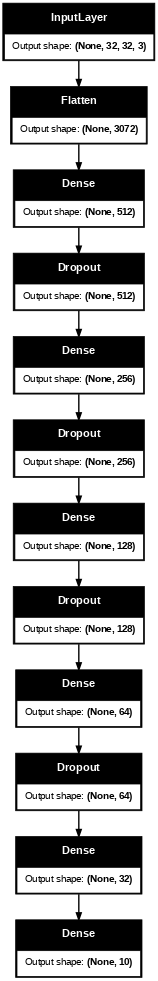

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=2,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 - 10s - 32ms/step - accuracy: 0.5352 - loss: 1.2936 - val_accuracy: 0.4819 - val_loss: 1.4622
Epoch 2/200
313/313 - 12s - 40ms/step - accuracy: 0.5344 - loss: 1.2946 - val_accuracy: 0.4951 - val_loss: 1.4467
Epoch 3/200
313/313 - 10s - 34ms/step - accuracy: 0.5347 - loss: 1.2875 - val_accuracy: 0.4728 - val_loss: 1.4786
Epoch 4/200
313/313 - 20s - 64ms/step - accuracy: 0.5359 - loss: 1.2896 - val_accuracy: 0.4858 - val_loss: 1.4713
Epoch 5/200
313/313 - 10s - 31ms/step - accuracy: 0.5365 - loss: 1.2912 - val_accuracy: 0.4897 - val_loss: 1.4559
Epoch 6/200
313/313 - 11s - 34ms/step - accuracy: 0.5370 - loss: 1.2842 - val_accuracy: 0.4866 - val_loss: 1.4530
Epoch 7/200
313/313 - 11s - 34ms/step - accuracy: 0.5392 - loss: 1.2803 - val_accuracy: 0.4837 - val_loss: 1.4647
Epoch 8/200
313/313 - 22s - 70ms/step - accuracy: 0.5422 - loss: 1.2715 - val_accuracy: 0.4886 - val_loss: 1.4668
Epoch 9/200
313/313 - 20s - 63ms/step - accuracy: 0.5443 - loss: 1.2703 - val_accuracy: 

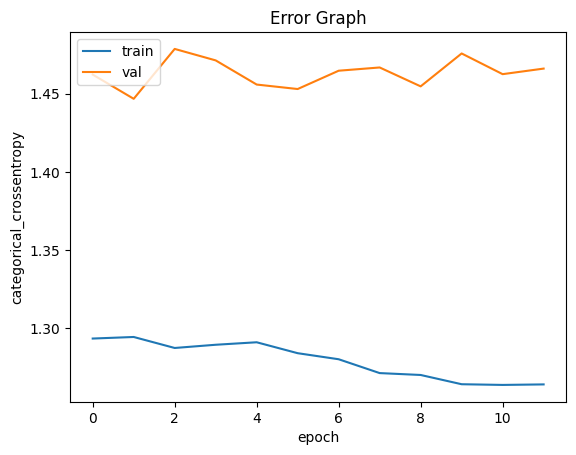

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4392119646072388
Test accuracy: 0.49079999327659607


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


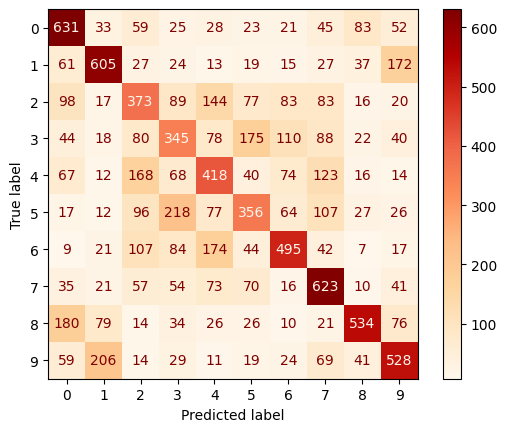

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
#target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']
target_names = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

       avión       0.53      0.63      0.57      1000
   automóvil       0.59      0.60      0.60      1000
      pájaro       0.37      0.37      0.37      1000
        gato       0.36      0.34      0.35      1000
      venado       0.40      0.42      0.41      1000
       perro       0.42      0.36      0.39      1000
        rana       0.54      0.49      0.52      1000
     caballo       0.51      0.62      0.56      1000
       barco       0.67      0.53      0.60      1000
      camión       0.54      0.53      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta:` Las "skip connections" (conexiones de salto) son una técnica arquitectónica en las redes neuronales que se utilizan para abordar problemas como la desaparición del gradiente durante el entrenamiento profundo y mejorar la propagación de la información en capas profundas. También son conocidas como "conexiones residuales" y son un componente fundamental en las arquitecturas de redes neuronales como ResNet (Residual Networks).

El problema principal que las skip connections resuelven es la degradación del rendimiento al aumentar la profundidad de una red neuronal. A medida que una red se vuelve más profunda, puede volverse más difícil entrenarla debido a la "desaparición del gradiente". Este problema ocurre cuando los gradientes que se propagan hacia atrás durante el entrenamiento se vuelven muy pequeños a medida que se profundiza en la red, lo que dificulta que las capas anteriores aprendan de manera efectiva.

Las skip connections abordan este problema al permitir que las capas de una red neuronal aprendan residuos o diferencias entre las entradas y las salidas. En lugar de forzar una capa a aprender a mapear directamente las entradas a las salidas, las skip connections permiten que las capas aprendan a mapear las entradas a las diferencias entre las entradas y las salidas esperadas. Esto permite que las capas aprendan cambios más sutiles y, por lo tanto, facilita el entrenamiento profundo.

Cómo funcionan las skip connections:

1. *Conexión Directa:* En una skip connection, la entrada de una capa se agrega directamente a la salida de otra capa. En lugar de tener solo una secuencia lineal de capas que se encadenan, ahora hay una conexión directa que "salta" capas intermedias.

2. *Aprendizaje de Residuos:* En lugar de aprender la función completa para mapear la entrada a la salida, una capa en una skip connection se entrena para aprender el residuo entre la entrada y la salida. Es decir, en lugar de predecir la salida completa, la capa aprende a predecir la diferencia entre la salida esperada y la entrada actual.

3. *Agregación:* La salida de la capa intermedia (que aprendió el residuo) se suma a la entrada de la capa siguiente. Esta suma de la entrada original y el residuo aprendido crea la salida final de la skip connection.

4. *Beneficios:* La adición de la entrada original a la salida de la capa intermedia tiene un efecto de "short-circuiting" (cortocircuito). Si las capas intermedias no logran aprender ninguna mejora útil, la suma simplemente se aproxima a la entrada original, evitando la degradación del rendimiento.

En resumen, las skip connections resuelven problemas de entrenamiento profundo al permitir que las capas aprendan residuos o diferencias entre entradas y salidas, lo que hace que sea más fácil para las capas aprender cambios más sutiles. Esto mejora la propagación de la información, evita la desaparición del gradiente y ha demostrado ser extremadamente efectivo en la creación de arquitecturas de redes neuronales profundas y altamente eficaces como ResNet.

In [ ]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (238.17 MB)

 Trainable params: 7,803,338 (238.14 MB)

 Non-trainable params: 896 (28.00 KB)

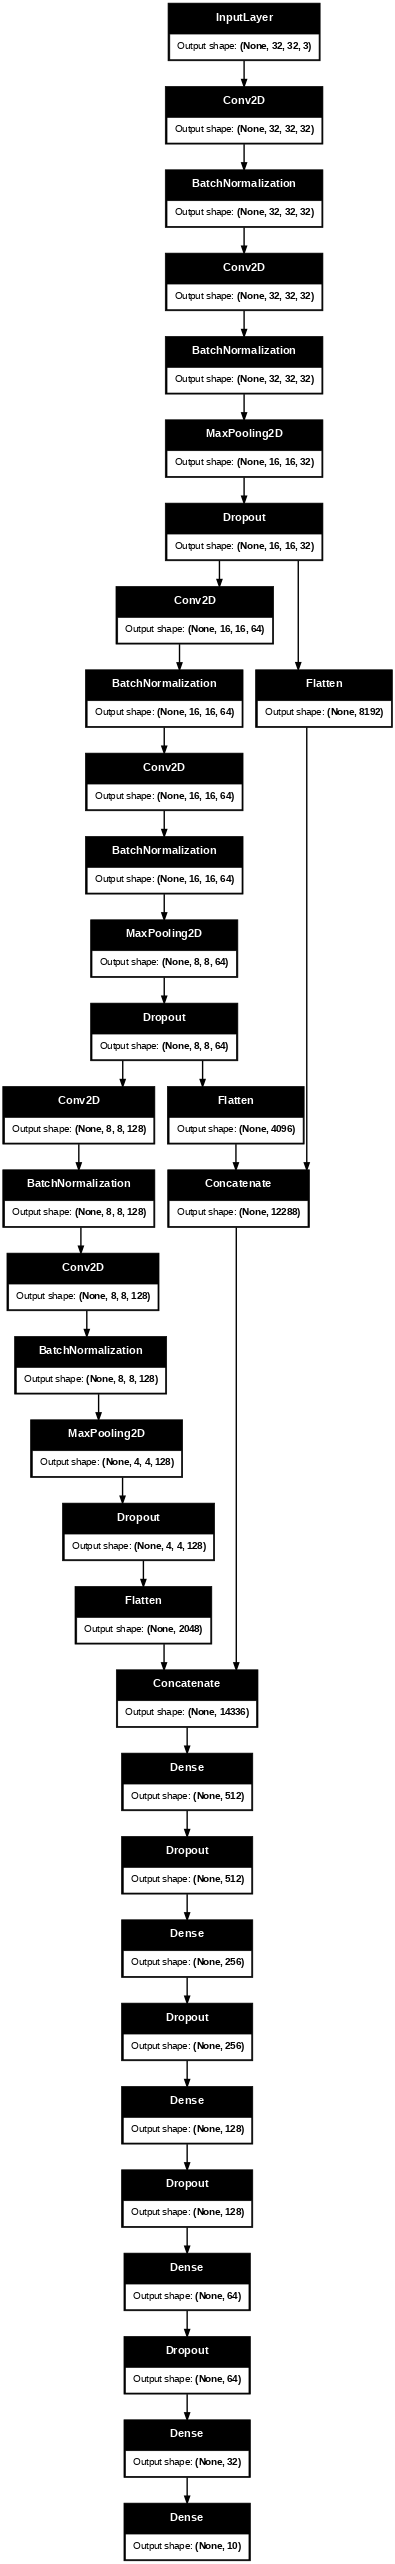

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [ ]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
#target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']
target_names = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [ ]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [ ]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

In [ ]:
plot_losses(history, loss)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/AlejandroVillazonG/Tareas_INF395/main/Steel_industry_data.csv')

In [ ]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [ ]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

info = datainfo(df)

In [ ]:
print(info)

                                     DataType  Non-null_Values  Unique_Values  \
date                                   object            35040          35040   
Usage_kWh                             float64            35040           3343   
Lagging_Current_Reactive.Power_kVarh  float64            35040           1954   
Leading_Current_Reactive_Power_kVarh  float64            35040            768   
CO2(tCO2)                             float64            35040              8   
Lagging_Current_Power_Factor          float64            35040           5079   
Leading_Current_Power_Factor          float64            35040           3366   
NSM                                     int64            35040             96   
WeekStatus                             object            35040              2   
Day_of_week                            object            35040              7   
Load_Type                              object            35040              3   

                           

In [ ]:
numericas_int = list(info[info['DataType'] == 'int64'].index)
numericas_float = list(info[info['DataType'] == 'float64'].index)

print('Numeric variables:')
total_int = 1
for i,variable in enumerate(numericas_int):
    print(f'   {i+1}. (int) {variable}')
    total = i + 1
for i,variable in enumerate(numericas_float):
    print(f'   {total+i+1}. (float) {variable}')
print('\n')

# Selecting the categoric variables
categoricas = list(info[info['DataType'] == 'object'].index)
print(' Categoric variables:')
for i,variable in enumerate(categoricas):
    print(f'   {i+1}. {variable}')

Numeric variables:
   1. (int) NSM
   2. (float) Usage_kWh
   3. (float) Lagging_Current_Reactive.Power_kVarh
   4. (float) Leading_Current_Reactive_Power_kVarh
   5. (float) CO2(tCO2)
   6. (float) Lagging_Current_Power_Factor
   7. (float) Leading_Current_Power_Factor


 Categoric variables:
   1. date
   2. WeekStatus
   3. Day_of_week
   4. Load_Type


**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

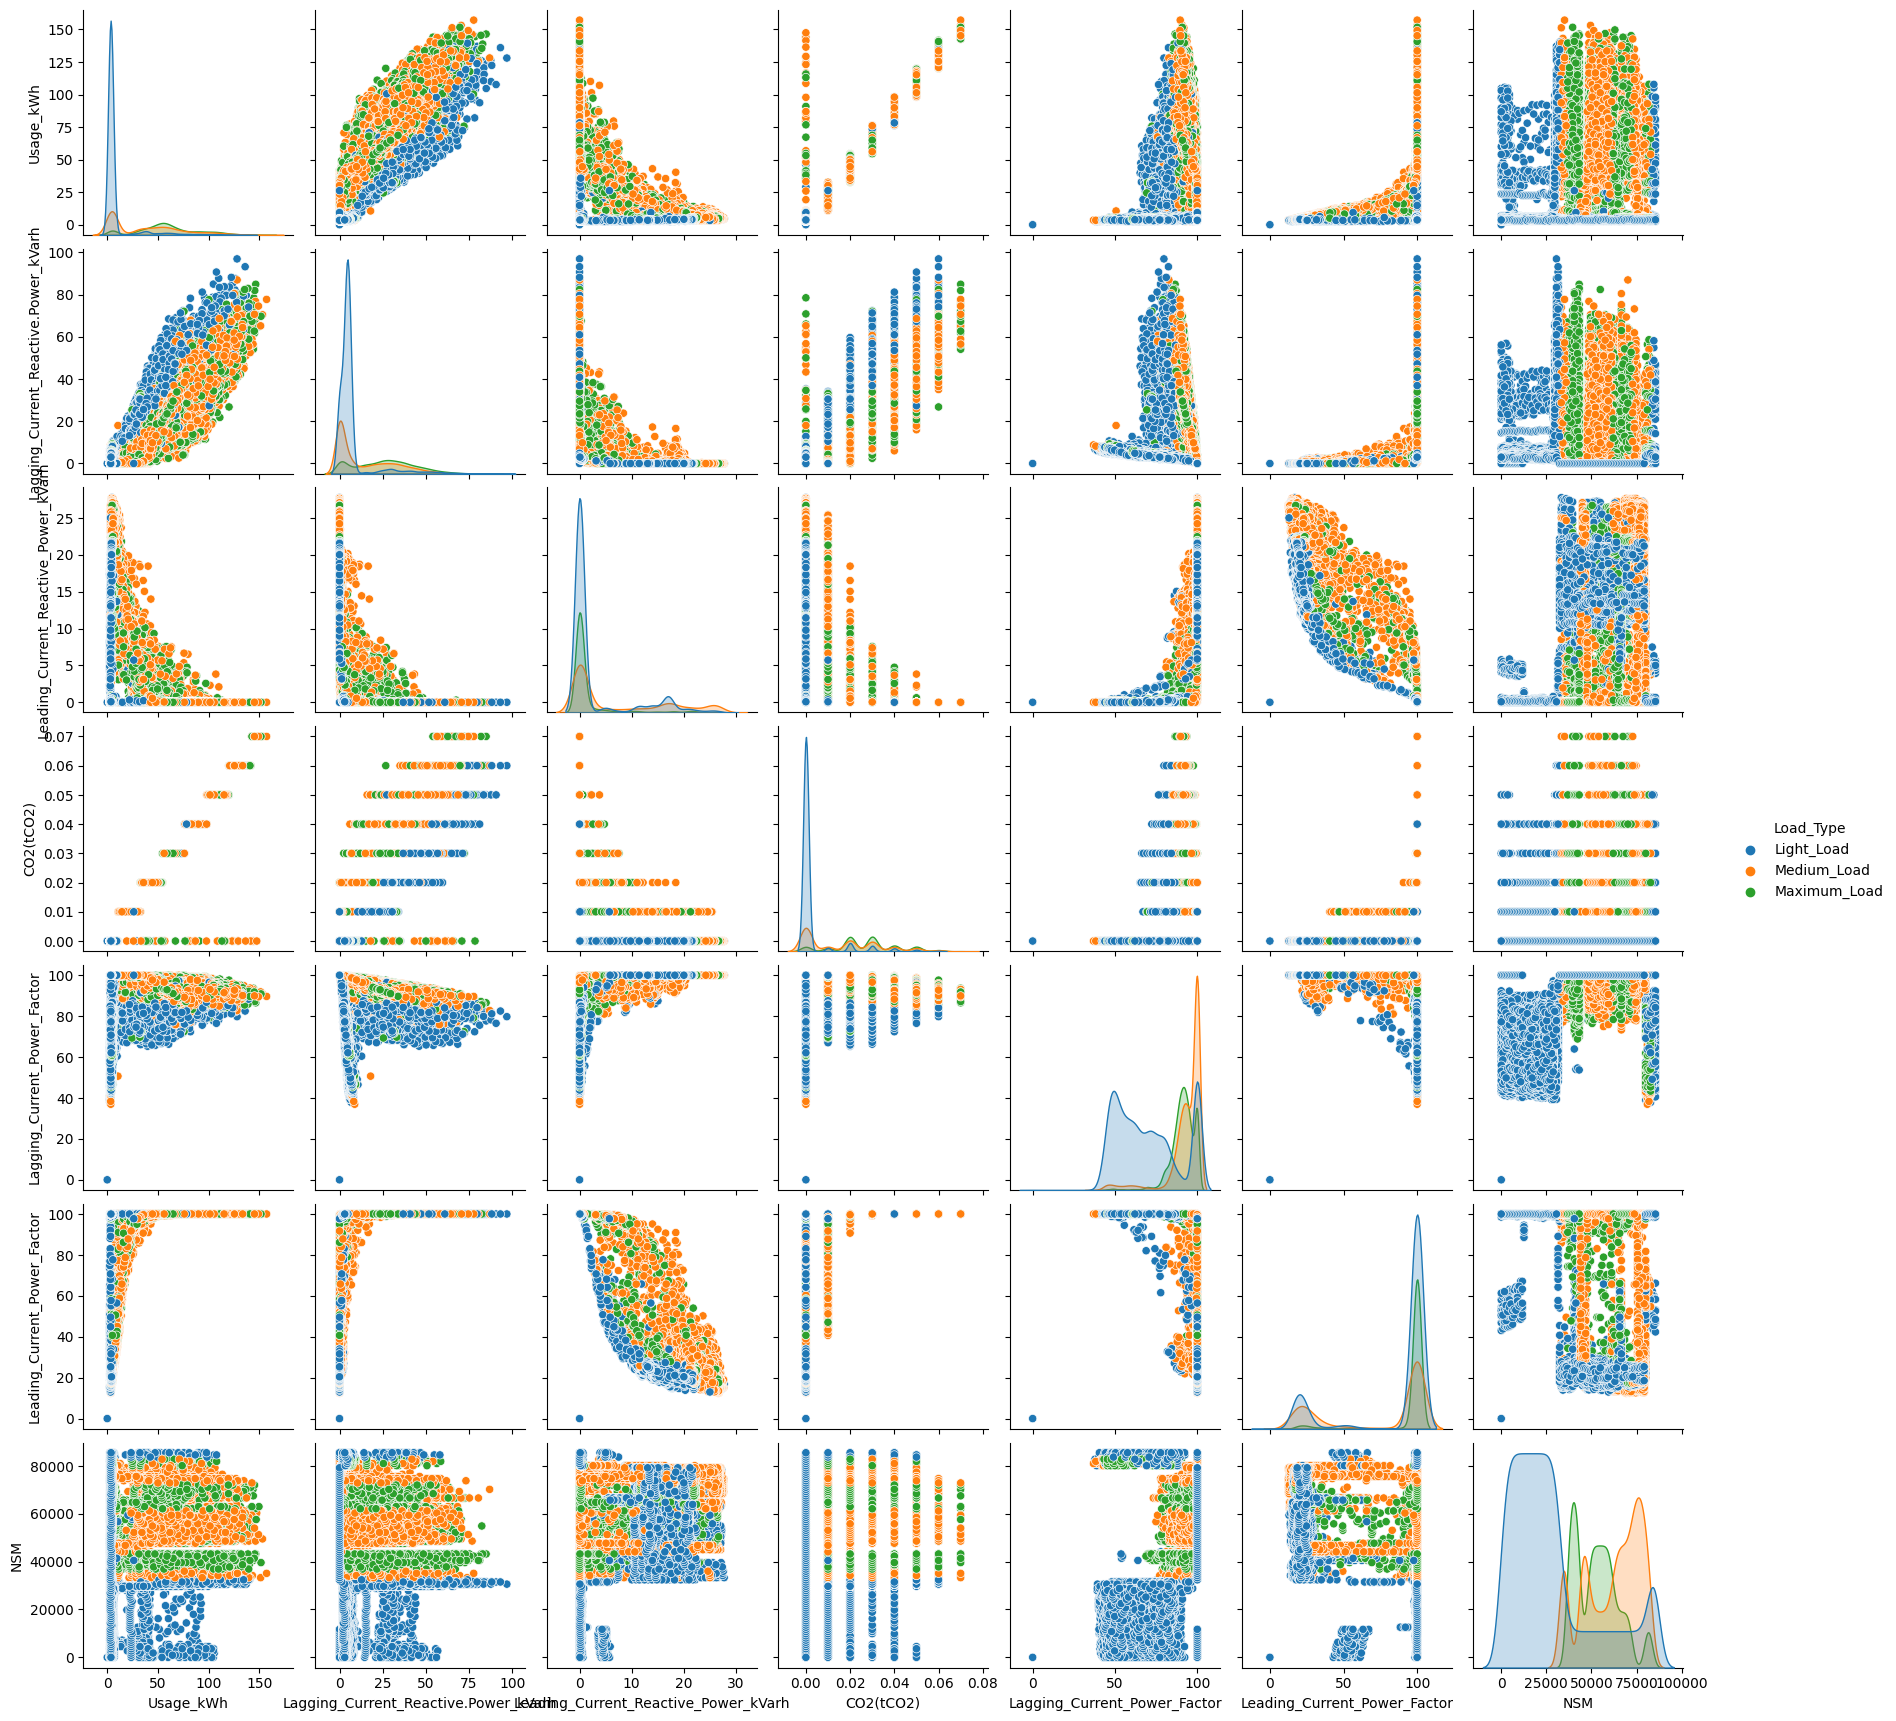

In [ ]:
sns.pairplot(df, hue='Load_Type')

In [ ]:
#Gráficos del EDA
### START CODE HERE ###
## Revisar que estén bien balanceadas las clases

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

`Respuesta:`
*   `Training`:
*   `Validation`:
*   `Testing`:

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir la data considerando el split indicado anteriormente (se recomienda separar en train y test en esta sección, y separar en validación en la sección de entrenamiento)
### START CODE HERE ###
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Usage_kWh'], axis = 1), df['Usage_kWh'], test_size=0.1, random_state=SEED)

In [ ]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 3283
Dimension de los datos: (10,)


### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

`Respuesta:`

In [ ]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [ ]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,sin_day,cos_day
0,0.017213,0.999852
1,0.034422,0.999407
2,0.051620,0.998667
3,0.068802,0.997630
4,0.085965,0.996298


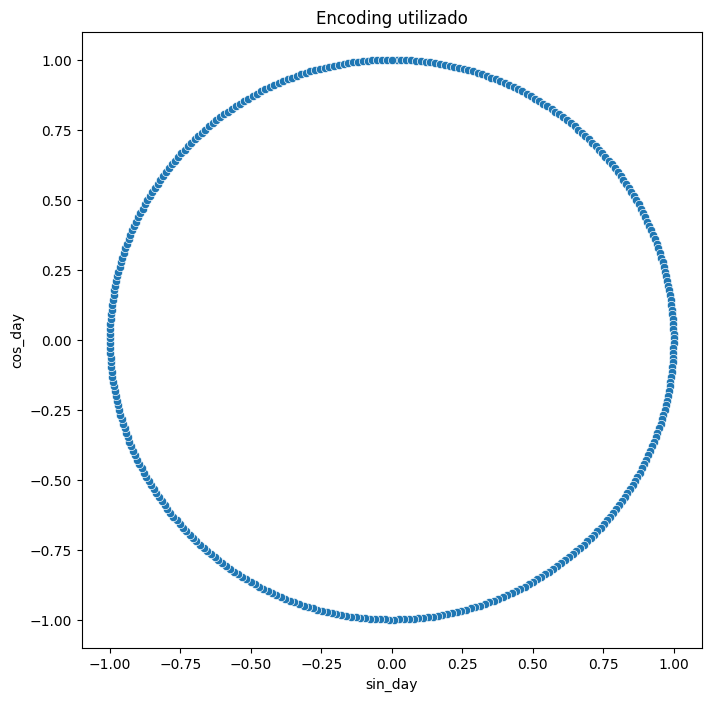

In [ ]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 8))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]


`Respuesta:`

*   `One-Hot Encoding`:
*   `Ordinal Encoding`:
*   `Label Encoding`:

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

minmax_scaler = MinMaxScaler(feature_range=(0, 1))
standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

# Aplicar MinMaxScaler
X_train[['CO2(tCO2)', 'NSM']] = minmax_scaler.fit_transform(X_train[['CO2(tCO2)', 'NSM']])
X_test[['CO2(tCO2)', 'NSM']] = minmax_scaler.transform(X_test[['CO2(tCO2)', 'NSM']])

# Aplicar StandardScaler
X_train[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']] = standard_scaler.fit_transform(X_train[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                                                                                                     'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']])
X_test[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']] = standard_scaler.transform(X_test[['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                                                                                                     'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']])

# Aplicar Ordinal Encoding
X_train['Load_Type'] = ordinal_encoder.fit_transform(X_train['Load_Type'].values.reshape((-1,1)))
X_test['Load_Type'] = ordinal_encoder.transform(X_test['Load_Type'].values.reshape((-1,1)))

# Aplicar One-Hot Encoding
week_status_encoded = onehot_encoder.fit_transform(X_train[['WeekStatus']]).toarray()
week_status_columns = [f"WeekStatus_{status}" for status in onehot_encoder.categories_[0]]
X_train[week_status_columns] = week_status_encoded
X_train = X_train.drop(['WeekStatus'], axis = 1)

week_status_encoded = onehot_encoder.transform(X_test[['WeekStatus']]).toarray()
week_status_columns = [f"WeekStatus_{status}" for status in onehot_encoder.categories_[0]]
X_test[week_status_columns] = week_status_encoded
X_test = X_test.drop(['WeekStatus'], axis = 1)

# Aplicar Label Encoding
X_train['Day_of_week'] = label_encoder.fit_transform(X_train['Day_of_week'])
X_test['Day_of_week'] = label_encoder.transform(X_test['Day_of_week'])

In [ ]:
X_train.head()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend
14833,04/06/2018 12:30,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,Weekday,1,2.0,1.0,0.0
7974,25/03/2018 01:45,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,Weekend,3,0.0,0.0,1.0
25807,26/09/2018 20:00,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,Weekday,6,0.0,1.0,0.0
5987,04/03/2018 09:00,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,Weekend,3,0.0,0.0,1.0
15757,14/06/2018 03:30,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,Weekday,4,0.0,1.0,0.0


In [ ]:
X_train[['dia', 'hora']] = X_train['date'].str.split(' ', expand = True)
X_train[['dia', 'mes', 'año']] = X_train['dia'].str.split('/', expand = True).astype(int)
X_train['hora'] =  X_train['hora'].str.split(':', expand = True)[0].astype(int)
X_test[['dia', 'hora']] = X_test['date'].str.split(' ', expand = True)
X_test[['dia', 'mes', 'año']] = X_test['dia'].str.split('/', expand = True).astype(int)
X_test['hora'] =  X_test['hora'].str.split(':', expand = True)[0].astype(int)

In [ ]:
X_train.head()

,date,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,dia,hora,mes,año
14833,04/06/2018 12:30,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,2.0,1.0,0.0,4,12,6,2018
7974,25/03/2018 01:45,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,25,1,3,2018
25807,26/09/2018 20:00,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,26,20,9,2018
5987,04/03/2018 09:00,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,4,9,3,2018
15757,14/06/2018 03:30,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,14,3,6,2018


In [ ]:
print(X_train['año'].unique())
print(X_test['año'].unique())

[2018]
[2018]


In [ ]:
X_train = X_train.drop(['año', 'date'], axis = 1)
X_test = X_test.drop(['año', 'date'], axis = 1)

In [ ]:
X_train.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,dia,hora,mes
14833,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,2.0,1.0,0.0,4,12,6
7974,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,25,1,3
25807,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,26,20,9
5987,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,4,9,3
15757,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,14,3,6


In [ ]:
# Verificamos si es año bisiesto
max(X_train['dia'])

31

In [ ]:
#X_train = preprocess_time(X_train, "day", 365)
#X_test = preprocess_time(X_test, "day", 365)

X_train = preprocess_time(X_train, "mes", 12)
X_test = preprocess_time(X_test, "mes", 12)

X_train = preprocess_time(X_train, "hora", 24)
X_test = preprocess_time(X_test, "hora", 24)

In [ ]:
X_train.head()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_Weekday,WeekStatus_Weekend,dia,sin_mes,cos_mes,sin_hora,cos_hora
14833,-0.799577,2.603502,0.0,1.025560,-2.078090,0.526316,1,2.0,1.0,0.0,4,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000
7974,-0.582954,-0.522085,0.0,-0.799566,0.513479,0.073684,3,0.0,0.0,1.0,25,1.000000e+00,6.123234e-17,2.588190e-01,0.965926
25807,-0.799577,1.052823,0.0,1.025560,-2.020646,0.842105,6,0.0,1.0,0.0,26,-1.000000e+00,-1.836970e-16,-8.660254e-01,0.500000
5987,-0.799577,1.237235,0.0,1.025560,-1.970094,0.378947,3,0.0,0.0,1.0,4,1.000000e+00,6.123234e-17,7.071068e-01,-0.707107
15757,-0.538770,-0.522085,0.0,-1.220667,0.513479,0.147368,4,0.0,1.0,0.0,14,1.224647e-16,-1.000000e+00,7.071068e-01,0.707107


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [ ]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
y_train = '''TODO'''
X_train = '''TODO'''

y_test = '''TODO'''
X_test = '''TODO'''

## ??????????????????????????????

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [ ]:
print(f'Training:\n {min(y_train) = }\n {max(y_train) = }')
print(f'Test:\n {min(y_test) = }\n {max(y_test) = }')

dif = max(y_train)-min(y_train)

Training:
 min(y_train) = 0.0
 max(y_train) = 157.18
Test:
 min(y_test) = 2.45
 max(y_test) = 153.14


In [ ]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
inputs = keras.layers.Input(shape=(X_train.shape[1:]))
x =  keras.layers.Dense(128, activation='relu')(inputs)
outputs = keras.layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │      2,048 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,177 (68.03 KB)

 Trainable params: 2,177 (68.03 KB)

 Non-trainable params: 0 (0.00 B)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`:

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [ ]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [ ]:
### START CODE HERE ###
epochs = 200
batch_size = 128
val_split = 0.1
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
] #si va a implementar early stopping, asegurese de retornar los mejores pesos

### 2.6 Entrenando el Modelo

In [ ]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=2)

Epoch 1/200
222/222 - 8s - 38ms/step - loss: 894.2339 - mean_absolute_error: 20.0828 - mean_squared_error: 894.9138 - root_mean_squared_error: 29.9151 - val_loss: 277.7828 - val_mean_absolute_error: 10.7173 - val_mean_squared_error: 275.8029 - val_root_mean_squared_error: 16.6073
Epoch 2/200
222/222 - 1s - 2ms/step - loss: 136.4814 - mean_absolute_error: 7.6469 - mean_squared_error: 136.5509 - root_mean_squared_error: 11.6855 - val_loss: 80.3273 - val_mean_absolute_error: 6.3264 - val_mean_squared_error: 80.0977 - val_root_mean_squared_error: 8.9497
Epoch 3/200
222/222 - 1s - 3ms/step - loss: 66.8168 - mean_absolute_error: 5.9197 - mean_squared_error: 66.8435 - root_mean_squared_error: 8.1758 - val_loss: 55.5798 - val_mean_absolute_error: 5.5372 - val_mean_squared_error: 55.4438 - val_root_mean_squared_error: 7.4461
Epoch 4/200
222/222 - 1s - 3ms/step - loss: 49.6600 - mean_absolute_error: 5.2986 - mean_squared_error: 49.6794 - root_mean_squared_error: 7.0484 - val_loss: 43.8911 - val_

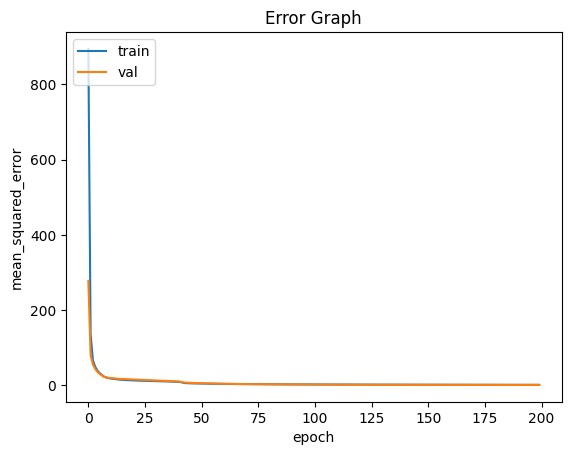

In [ ]:
plot_losses(history, loss)

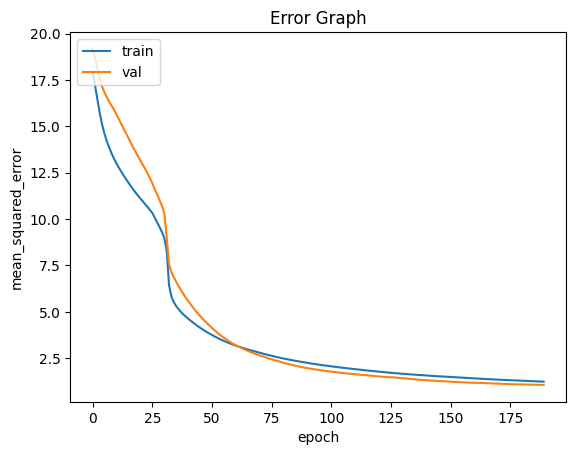

In [ ]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Error Graph')
plt.ylabel(loss.name)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


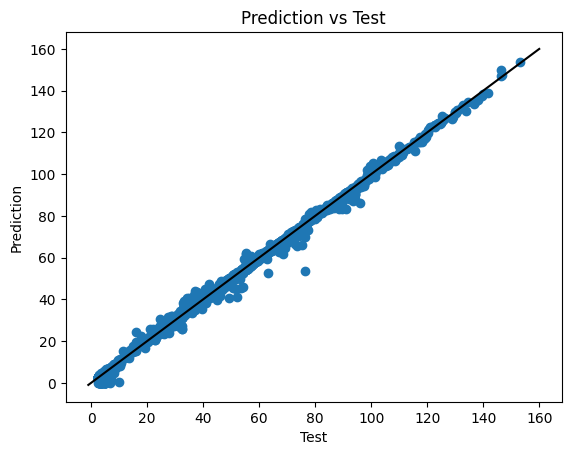

In [ ]:
plt.scatter(y_test, model.predict(X_test))

plt.plot([-1,160], [-1,160], c='black')

plt.xlabel('Test')
plt.ylabel('Prediction')
plt.title('Prediction vs Test')

plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test mean_squared_error:", score[1])
print("Test mean_absolute_error:", score[2])
print("Test root_mean_squared_error:", score[3])

Test loss: 1.491172194480896
Test mean_squared_error: 0.5717992782592773
Test mean_absolute_error: 1.4917750358581543
Test root_mean_squared_error: 1.2213823795318604


Notando que la diferencia máxima de los datos es aproximadamente 150, aseguramos que el error posee un orden de magnitud muy inferior al de los datos, por lo que nuestra predicción es bastante cercana, como se evidencia en el gráfico comparativo.

### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [ ]:
model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.